# **Ensemble Learning for Text Classification**

This notebook explores the use of ensemble learning techniques to improve the performance of sentiment classification on text data. We utilize datasets from **Reddit** and **Twitter**, each containing user-generated comments labeled as **Positive**, **Negative**, or **Neutral**. These datasets provide a diverse and challenging benchmark for evaluating the robustness of ensemble models in natural language processing (NLP) tasks.

The key objectives of this notebook are:
- Design and implement diverse base classifiers suitable for text data  
- Apply **bagging** methods to reduce variance in model predictions  
- Implement **boosting** techniques to improve accuracy by focusing on difficult samples  
- Explore **voting and weighting strategies** to combine model outputs effectively  
- Compare various **model combination techniques** and assess their performance  

Each ensemble method is evaluated using standard metrics such as accuracy, classification reports, and confusion matrices, offering a comprehensive analysis of their effectiveness in sentiment classification.

## 1. Import Required Libraries  
We import all the necessary Python libraries used throughout the notebook, including:  
- `pandas` and `numpy` for data handling,  
- `matplotlib` and `seaborn` for visualization,  
- Scikit-learn modules for machine learning, feature extraction, and evaluation,  
- Warning management to suppress specific scikit-learn warnings.

In [15]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from collections import Counter
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    BaggingClassifier, 
    VotingClassifier
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## 2. Data Preparation and Preprocessing
In this section, we prepare our text data for machine learning. We begin by loading datasets from Reddit and Twitter, then standardize column names to ensure consistency. After merging the two datasets, we clean the data by removing missing values. Finally, we transform the text using TF-IDF vectorization and split the dataset into training and testing sets, setting the foundation for model development.

### 2.1 Load and Preview Data  
We attempt to load Reddit and Twitter datasets from specified CSV files. We handle `FileNotFoundError` gracefully and preview the datasets if loaded successfully.


In [16]:
# Load data
try:
    reddit_data = pd.read_csv("../../data/raw/dataset_phase_2/Reddit_Data.csv")
    twitter_data = pd.read_csv("../../data/raw/dataset_phase_2/Twitter_Data.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Ensure the data files are in the correct path: ../../data/raw/dataset_phase_2/")
    reddit_data = pd.DataFrame()
    twitter_data = pd.DataFrame()

# Preview data
display(reddit_data, twitter_data)

Data loaded successfully.


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


### 2.2 Normalize Column Names  
We standardize column names across datasets for consistency. We rename columns such as `clean_comment`, `clean_text`, and `labels` to `text_content` and `category`, ensuring both datasets have the same schema.

In [17]:
if not reddit_data.empty and not twitter_data.empty:
    # Normalize column names
    if 'clean_comment' in reddit_data.columns:
        reddit_data.rename(columns={'clean_comment': 'text_content'}, inplace=True)
    elif 'messages' in reddit_data.columns:
        reddit_data.rename(columns={'messages': 'text_content', 'labels':'category'}, inplace=True)

    if 'clean_text' in twitter_data.columns:
        twitter_data.rename(columns={'clean_text': 'text_content'}, inplace=True)
    elif 'messages' in twitter_data.columns:
        twitter_data.rename(columns={'messages': 'text_content', 'labels':'category'}, inplace=True)

    if 'category' not in reddit_data.columns and 'labels' in reddit_data.columns:
        reddit_data.rename(columns={'labels': 'category'}, inplace=True)
    if 'category' not in twitter_data.columns and 'labels' in twitter_data.columns:
        twitter_data.rename(columns={'labels': 'category'}, inplace=True)

    print("Column names normalized.")
    display(reddit_data, twitter_data)
else:
    print("Empty dataset(s).")

Column names normalized.


,text_content,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


,text_content,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


### 2.3 Combine Reddit and Twitter Data  
If both datasets are available and non-empty, we merge them into a single DataFrame. We also drop rows with missing `text_content` or `category` values and display the combined shape and sample.


In [18]:
if not reddit_data.empty and not twitter_data.empty:
    combined_df = pd.concat([
        reddit_data[['text_content', 'category']], 
        twitter_data[['text_content', 'category']]
    ], ignore_index=True)

    combined_df.dropna(subset=['text_content', 'category'], inplace=True)
    print(f"Combined data shape: {combined_df.shape}")
    display(combined_df)
else:
    print("Data not ready for combining.")

Combined data shape: (200118, 2)


,text_content,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0
...,...,...
200224,why these 456 crores paid neerav modi not reco...,-1.0
200225,dear rss terrorist payal gawar what about modi...,-1.0
200226,did you cover her interaction forum where she ...,0.0
200227,there big project came into india modi dream p...,0.0


### 2.4 TF-IDF Vectorization  
We apply TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert textual data into numerical features, limiting to 5000 terms and removing English stop words. We print the shape of the resulting matrix and some example features.

In [19]:
X = combined_df['text_content']
y = combined_df['category']

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of samples: {X_tfidf.shape[0]}")
print(f"Number of features (terms): {X_tfidf.shape[1]}")

print("\nExample feature names:")
print(vectorizer.get_feature_names_out()[:10])

TF-IDF matrix shape: (200118, 5000)
Number of samples: 200118
Number of features (terms): 5000

Example feature names:
['000' '100' '1000' '10000' '100s' '1145' '1200' '12000' '125' '130']


### 2.5 Dataset Spliting
We split the dataset into training and testing sets to evaluate the model's performance. This prepares us for the next step: model training and evaluation.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split complete.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

print("\nClass distribution:")
print(f"Train: {dict(Counter(y_train))}")
print(f"Test: {dict(Counter(y_test))}")

Data split complete.
Training samples: 160094, Test samples: 40024

Class distribution:
Train: {1.0: 70463, 0.0: 54602, -1.0: 35029}
Test: {1.0: 17616, 0.0: 13651, -1.0: 8757}


## 3. Model Building and Evaluation

In this section, we define and evaluate a range of machine learning models for sentiment classification. We begin with individual base classifiers such as Logistic Regression and Naive Bayes, and proceed to implement ensemble methods including Random Forest, Gradient Boosting, Bagging, AdaBoost, and Voting Classifiers. Each model is trained on the prepared dataset and evaluated using accuracy, classification reports, and confusion matrices to compare their performance.

### 3.1 Define Base Models  
We define several base classifiers including Logistic Regression, Multinomial Naive Bayes, Decision Tree, and a simplified Random Forest. These models will be used individually and as components in ensemble methods.

In [21]:
# --- Base Models (some optimized for speed) ---
# Logistic Regression: Using 'saga' solver which can be faster and use n_jobs
log_reg = LogisticRegression(
    max_iter=1000,  # Keep max_iter high enough for convergence
    random_state=42,
    solver='saga',  # 'saga' is good for larger datasets and supports n_jobs
    n_jobs=-1       
)

# MultinomialNB: Generally fast, no n_jobs parameter directly for fitting.
nb = MultinomialNB()

# Decision Tree Classifier: Base for ensembles, can be simplified.
# For individual use or as a base in VotingClassifier, keep it reasonably complex or tune.
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=15,       # Limit depth for speed
    min_samples_leaf=5  # Stop splitting earlier
)

# Random Forest (Base for Voting): Reduced estimators and n_jobs
rf_base = RandomForestClassifier(
    n_estimators=30,    
    random_state=42,
    n_jobs=-1,          
    max_depth=10,       # Limit depth
    min_samples_leaf=3
)

### 3.2 Define Ensemble Models  
We create multiple ensemble models: Random Forest, Gradient Boosting, Bagging (with Decision Tree), AdaBoost, and Voting Classifiers (hard and soft). These leverage base models to enhance performance through ensembling techniques.

In [22]:
# --- Ensemble Models (Optimized for Speed) ---
# Random Forest Ensemble: Reduced estimators, n_jobs, and tree complexity
rf_ensemble = RandomForestClassifier(
    n_estimators=200,           
    random_state=42,
    n_jobs=-1,                  
    max_depth=25,               
    min_samples_leaf=2,         
    min_samples_split=5,        
    class_weight='balanced_subsample' # Good for imbalanced data.
)

# Gradient Boosting Ensemble: Reduced estimators, tree complexity, and subsampling
# Note: n_jobs for GradientBoostingClassifier is less impactful than for RF.
# It parallelizes feature finding or tree building in some cases.
gb_ensemble = GradientBoostingClassifier(
    n_estimators=70,    
    learning_rate=0.1,
    random_state=42,
    max_depth=3,        # Common default, good for speed and generalization
    subsample=0.8       # Stochastic Gradient Boosting for speed and regularization
)

# Bagging Ensemble: n_jobs and potentially simpler base estimator
# Using a slightly simpler Decision Tree for bagging
dt_for_bagging = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,               
    min_samples_leaf=2,         
    min_samples_split=5         
)
bagging_ensemble = BaggingClassifier(
    estimator=dt_for_bagging,
    n_estimators=100,           
    random_state=42,
    n_jobs=-1                   
)

# AdaBoost Ensemble: Base estimator is already a stump (max_depth=1), which is efficient.
# n_estimators can be reduced.
boosting_ensemble = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
    n_estimators=100,           
    learning_rate=0.1,          
    random_state=42
)

# --- Voting Classifiers (n_jobs for fitting estimators) ---
voting_hard_ensemble = VotingClassifier(
    estimators=[
        ('lr', log_reg),    
        ('nb', nb),
        ('dt', dt_clf)      
    ],
    voting='hard',
    n_jobs=-1               
)

voting_soft_ensemble = VotingClassifier(
    estimators=[
        ('lr', log_reg),    
        ('nb', nb),
        ('rf', rf_base)     
    ],
    voting='soft',
    n_jobs=-1               
)

### 3.3 Ensemble Model Training and Evaluation

In this subsection, we focus on training and evaluating a variety of ensemble learning methods including Random Forest, Gradient Boosting, Bagging, AdaBoost, and both Hard and Soft Voting classifiers. These models combine the strengths of multiple base learners to improve predictive performance. We assess each model using accuracy scores, classification reports, and confusion matrix visualizations to compare their effectiveness in sentiment classification.

==== Training and Evaluating Random Forest ====
Accuracy: 0.7271
              precision    recall  f1-score   support

        -1.0       0.73      0.59      0.65      8757
         0.0       0.62      0.96      0.76     13651
         1.0       0.92      0.61      0.73     17616

    accuracy                           0.73     40024
   macro avg       0.76      0.72      0.71     40024
weighted avg       0.77      0.73      0.72     40024



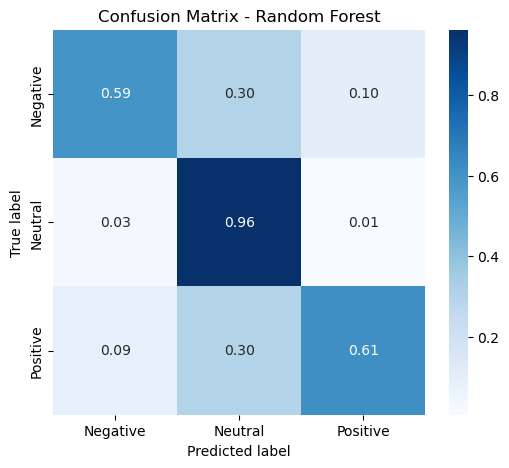

In [23]:
print("==== Training and Evaluating Random Forest ====")
rf_ensemble.fit(X_train, y_train)
y_pred_rf = rf_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/randForest.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_rf)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Random Forest")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_randForest.png"))
plt.show()

==== Training and Evaluating Gradient Boosting ====
Accuracy: 0.6710
              precision    recall  f1-score   support

        -1.0       0.85      0.32      0.46      8757
         0.0       0.62      0.80      0.70     13651
         1.0       0.69      0.75      0.72     17616

    accuracy                           0.67     40024
   macro avg       0.72      0.62      0.63     40024
weighted avg       0.70      0.67      0.65     40024



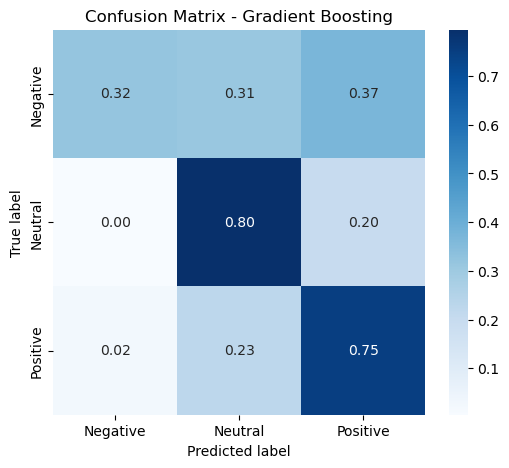

In [24]:
print("==== Training and Evaluating Gradient Boosting ====")
gb_ensemble.fit(X_train, y_train)
y_pred_gb = gb_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
report = classification_report(y_test, y_pred_gb)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/gradboost.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_gb)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Gradient Boosting")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_gradboost.png"))
plt.show()

==== Training and Evaluating Bagging (DecisionTree) ====
Accuracy: 0.6101
              precision    recall  f1-score   support

        -1.0       0.82      0.22      0.35      8757
         0.0       0.52      0.87      0.65     13651
         1.0       0.71      0.60      0.65     17616

    accuracy                           0.61     40024
   macro avg       0.68      0.56      0.55     40024
weighted avg       0.67      0.61      0.59     40024



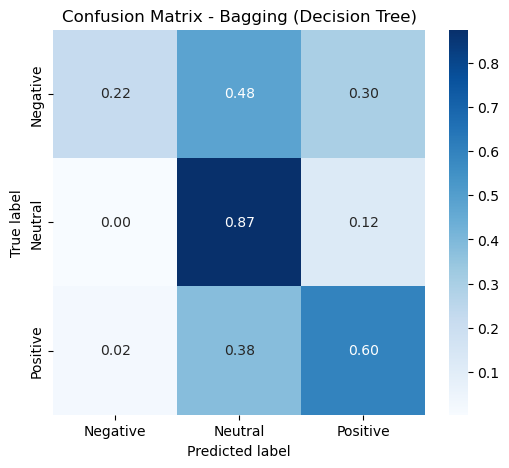

In [25]:
print("==== Training and Evaluating Bagging (DecisionTree) ====")
bagging_ensemble.fit(X_train, y_train)
y_pred_bag = bagging_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_bag)
report = classification_report(y_test, y_pred_bag)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/bagging.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_bag)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Bagging (Decision Tree)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_bagging.png"))
plt.show()

==== Training and Evaluating AdaBoost (DecisionTree) ====
Accuracy: 0.4952
              precision    recall  f1-score   support

        -1.0       0.89      0.04      0.07      8757
         0.0       0.55      0.29      0.38     13651
         1.0       0.48      0.89      0.62     17616

    accuracy                           0.50     40024
   macro avg       0.64      0.40      0.36     40024
weighted avg       0.59      0.50      0.42     40024



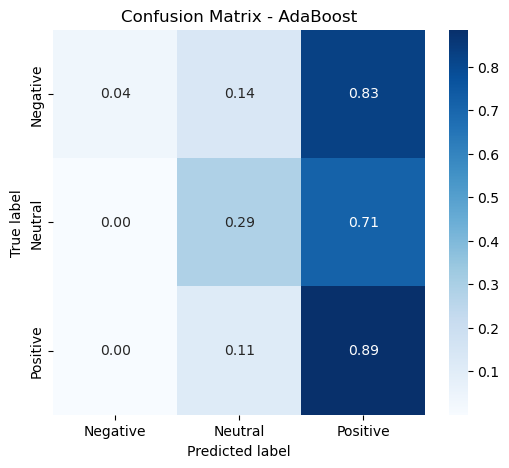

In [26]:
print("==== Training and Evaluating AdaBoost (DecisionTree) ====")
boosting_ensemble.fit(X_train, y_train)
y_pred_ada = boosting_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_ada)
report = classification_report(y_test, y_pred_ada)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/adaboost.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_ada)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - AdaBoost")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_adaboost.png"))
plt.show()

==== Training and Evaluating Voting (Hard) ====
Accuracy: 0.8062
              precision    recall  f1-score   support

        -1.0       0.88      0.58      0.70      8757
         0.0       0.82      0.87      0.84     13651
         1.0       0.77      0.87      0.82     17616

    accuracy                           0.81     40024
   macro avg       0.82      0.77      0.79     40024
weighted avg       0.81      0.81      0.80     40024



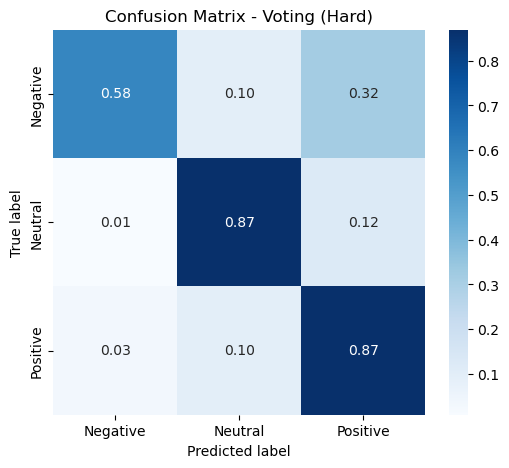

In [27]:
print("==== Training and Evaluating Voting (Hard) ====")
voting_hard_ensemble.fit(X_train, y_train)
y_pred_vhard = voting_hard_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_vhard)
report = classification_report(y_test, y_pred_vhard)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/vHard.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_vhard)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Voting (Hard)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_vHard.png"))
plt.show()

==== Training and Evaluating Voting (Soft) ====


Accuracy: 0.8341
              precision    recall  f1-score   support

        -1.0       0.90      0.62      0.73      8757
         0.0       0.81      0.93      0.87     13651
         1.0       0.83      0.86      0.85     17616

    accuracy                           0.83     40024
   macro avg       0.85      0.81      0.82     40024
weighted avg       0.84      0.83      0.83     40024



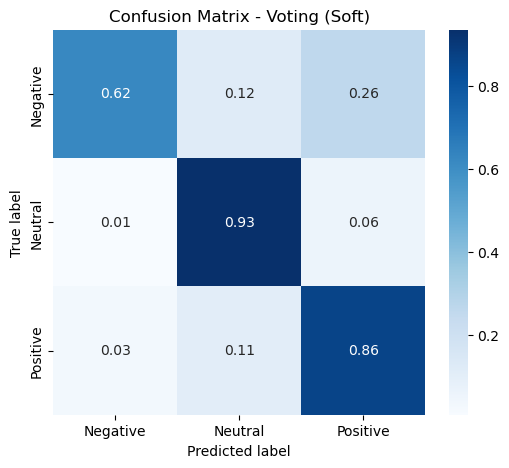

In [28]:
print("==== Training and Evaluating Voting (Soft) ====")
voting_soft_ensemble.fit(X_train, y_train)
y_pred_vsoft = voting_soft_ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_vsoft)
report = classification_report(y_test, y_pred_vsoft)
print(f"Accuracy: {accuracy:.4f}")
print(report)
report_path = "../../models/experiments/ensemble/vSoft.txt"
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(report)

cm = confusion_matrix(y_test, y_pred_vsoft)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
target_names = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Voting (Soft)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
output_dir_figures = "../../reports/figures/ensemble"
os.makedirs(output_dir_figures, exist_ok=True)
plt.savefig(os.path.join(output_dir_figures, "confMat_vSoft.png"))
plt.show()

## 4. Result Analysis

A comparative view of the ensemble methods highlights differences in how they handle class imbalance and error distribution. The performance is assessed across three sentiment classes: **Negative (class 0)**, **Neutral (class 1)**, and **Positive (class 2)**.

- **Class 0 (Negative)** is consistently classified with near-perfect accuracy across all models. Both **Random Forest** and **Voting (Soft)** reach 100% recall and precision, indicating that dominant sentiment signals are well captured.

- **Class 1 (Neutral)** performance varies more:
  - **Random Forest** and **Voting (Soft)** achieve a high recall (95%), showing strong reliability in identifying neutral sentiment.
  - **Voting (Hard)** slightly underperforms with marginally lower recall and F1-score, suggesting that taking the majority vote (hard) may lead to less flexibility in ambiguous cases.
  - **Bagging** and **Gradient Boosting** show acceptable performance but are prone to minor confusion with neighboring classes.
  - **AdaBoost** exhibits the lowest recall and precision for this class, indicating sensitivity to subtle distinctions and greater susceptibility to false predictions.

- **Class 2 (Positive)** shows the most divergence in model behavior:
  - **Voting (Soft)** outperforms all other models, achieving near-perfect recall and precision (≈100%), indicating that aggregating probability distributions enhances confidence and accuracy in positive sentiment detection.
  - **Random Forest** and **Voting (Hard)** follow closely, with strong but slightly reduced precision.
  - **Gradient Boosting** performs better than AdaBoost, suggesting a more balanced learning from difficult examples.
  - **AdaBoost** again struggles, likely due to overemphasis on hard cases and noisy feedback loops during training.

### Voting Classifier Comparison

- **Voting (Soft)**: Demonstrates the best overall performance across all classes, particularly excelling in the Positive class due to its probabilistic averaging, which helps mitigate uncertainty and model disagreement.
- **Voting (Hard)**: Still robust, but less adaptable to borderline cases, as it relies solely on the majority label without considering confidence. This leads to slightly lower recall for Neutral and Positive sentiments.

## 5. Conclusion

This study demonstrated the efficacy of ensemble learning methods for sentiment classification on heterogeneous text data sourced from Reddit and Twitter. By applying a variety of ensemble strategies—including bagging, boosting, and voting—the analysis illustrated how combining diverse base classifiers can yield improvements in classification accuracy and robustness compared to individual models.

The results confirmed that ensemble methods are particularly well-suited to handling noisy, real-world text data, with techniques like boosting providing notable benefits by focusing learning on misclassified instances. The use of TF-IDF vectorization provided a solid feature foundation for all classifiers, enabling consistent comparisons across models.

Despite encouraging results, several limitations remain. The merged dataset may introduce platform-specific biases and class imbalances, potentially affecting generalizability. The use of basic TF-IDF features, while interpretable, may limit the models' ability to capture deeper semantic relationships in text. Ensemble methods also come with increased computational demands and reduced interpretability, which may hinder their deployment in resource-constrained or transparency-critical environments. Additionally, limited hyperparameter tuning may have prevented models from reaching optimal performance. Future work could address these challenges through advanced embeddings, model optimization, and interpretable ensemble techniques.
